# Predicting the intersection location on the air-ice interface

In [1]:
import sys
print(sys.executable)


/home/byrne/anaconda3/envs/Europa/bin/python


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append("../../src")
from focus import *

## Define locations

In [3]:
sx = np.linspace(-10e3, 20e3, 1000)  # source x locations [m]
sz = 25000                        # source y locations [m]

# target
#tx, ty, tz = (5000, 5000, -1000)
tx, ty, tz = (5800, 5000,  -500)

## Load sim data

In [4]:
sltrng = np.load("sltrng.npy")

## Try and estimate slant range from source and target location

In [5]:
sltrng_ests = []
c1 = 299792458
c2 = c1 / np.sqrt(3.15)
for x in sx:
    # estimate surface intersections
    ix = snell_intersection(x, sz, tx, tz, c1, c2)
    sltrng_ests.append(np.sqrt((x - ix)**2 + sz**2) + np.sqrt((ix - tx)**2 + tz**2) * (c1/c2))
sltrng_ests = np.array(sltrng_ests)

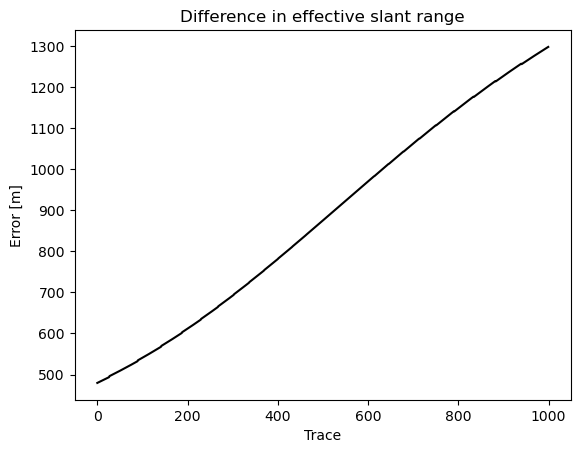

In [6]:
plt.plot(sltrng - sltrng_ests, color="black")
plt.title("Difference in effective slant range")
plt.xlabel("Trace")
plt.ylabel("Error [m]")
plt.show()

## Attempt at focusing with purely the slant range estimate

In [7]:
trc_min = np.argmin(sltrng_ests)
if trc_min < len(sltrng_ests) // 2:
    newsltrng = sltrng_ests[:-2 * int(len(sltrng_ests) // 2 - trc_min)]
elif trc_min > len(sltrng_ests) // 2:
    newsltrng = sltrng_ests[2 * int(trc_min - len(sltrng_ests) // 2):]
sltrng_ests = newsltrng

526


In [10]:
k = (2 * np.pi) / 33.3
match_filter_anl = np.exp(-2j * k * sltrng_ests)

In [11]:
rdrgrm = np.load("rdrgrm-offset.npy")

In [12]:
c        = 299792458 # speed of light [m/s]
f_y, y_x = 959, 50   # what pixel to focus? (range bin, trace)
lam      = 33.3      # wavelength [m]
rng_st   = 20e3      # starting range [m]
rng_en   = 50e3      # ending range [m]
rng_res  = 300       # range resolution [m]
sampl    = 48e6      # sampling rate [Hz]
dt       = 1 / sampl # time interval [s]
dt_m     = dt * c    # space interval [m]

# how many range bins?
rb = int(((rng_en - rng_st) / c) / (1 / sampl))

slant_rb = ((sltrng_ests - rng_st) // dt_m).astype(int)

In [13]:
focused = focus_jit(rdrgrm, slant_rb, match_filter_anl, 4803)

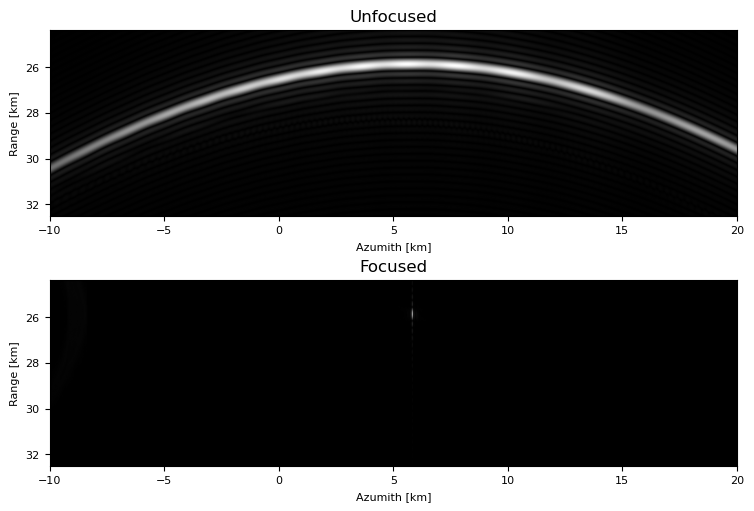

In [16]:
extent = (-10, 20, rng_en/1e3, rng_st/1e3)
fig, ax = plt.subplots(2, figsize=(10, 5), constrained_layout=True)
ax[0].imshow(np.abs(rdrgrm), cmap="gray", aspect=1, extent=extent)
ax[0].set_title("Unfocused")
ax[1].imshow(np.abs(focused), cmap="gray", aspect=1, vmax=3e-13, extent=extent)
ax[1].set_title("Focused")
for a in ax:
    a.set_ylim((rng_st + 2000 * dt_m)/1e3, (rng_st + 700 * dt_m)/1e3)
    a.set_xlabel("Azumith [km]", fontsize=8)
    a.set_ylabel("Range [km]", fontsize=8)
    a.tick_params(labelsize=8)
plt.show()

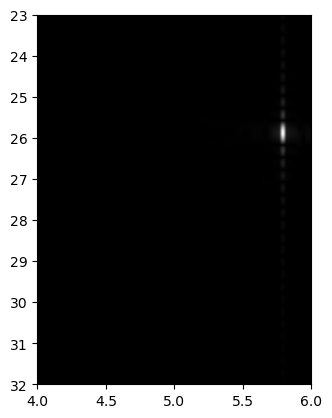

In [15]:
plt.imshow(np.abs(focused), cmap="gray", aspect=0.3, vmax=3e-13, extent=extent)
plt.ylim(32, 23)
plt.xlim(4, 6)
plt.show()